In [1]:
# Setup

import numpy as np
from matplotlib import pyplot as plt 
from matplotlib import dates
import pandas as pd

%matplotlib inline
# uncomment if you want plots external
#%matplotlib  

In [29]:
# load data

dfEsp = pd.read_pickle("Data/esp06062018.pkl")
#dfBte = pd.read_pickle("Data/bte62018.pkl")
#dfCme = pd.read_pickle("Data/cme62018.pkl")

In [30]:
def filterDf(df):
    # Add data
    df['pcPercent'] = (df['pA'] - df['pc'])/(df['pA'] - df['pB'])
    
    # Remove some data which we will not use for now
    df = df.drop(['eventNum', 'impQB', 'impQA', 'timeToExch', 'timeToLvlUpdt', 'workupState', 'workupPrice', 'ytrdPrice', 'ytrdOpenQty', 'ytrdHiddenQty', 'numInPacket', 'seqNumInst', 'seqNumUpdate', 'numLineInEvt', 'numOrdInTrade'], axis=1)

    return df

# call function
dfEsp = filterDf(dfEsp)
dfEsp.describe()

,instNum,qB,pB,pA,qA,pT,qT,vol,aggrSide,numPartB,numPartA,dT1,pc,pcPercent
count,642239.000000,642239.000000,642239.000000,642239.000000,642239.000000,642239.000000,642239.000000,642239.000000,642239.000000,642239.000000,642239.000000,642239.0,642239.000000,642239.000000
mean,2.780712,22.205040,99.752132,99.769515,24.729009,99.586044,0.048499,2402.068358,82.234659,12.794643,14.186829,0.0,99.760683,0.512335
std,1.349566,31.947499,0.363523,0.323591,39.852077,4.187686,0.418393,2452.988599,6.952365,9.347074,10.217367,0.0,0.332383,0.253355
min,0.000000,0.000000,0.000000,99.093750,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,50.429688,0.002695
25%,2.000000,5.000000,99.656250,99.687500,6.000000,99.671875,0.000000,499.000000,83.000000,4.000000,5.000000,0.0,99.671875,0.333333
50%,3.000000,15.000000,99.781250,99.796875,18.000000,99.789062,0.000000,1381.000000,85.000000,12.000000,13.000000,0.0,99.790296,0.500000
75%,4.000000,27.000000,99.914062,99.929688,30.000000,99.921875,0.000000,3819.000000,85.000000,19.000000,21.000000,0.0,99.921354,0.704918
max,5.000000,370.000000,100.890625,100.968750,583.000000,100.781250,67.000000,9781.000000,85.000000,56.000000,53.000000,0.0,100.921875,0.998288


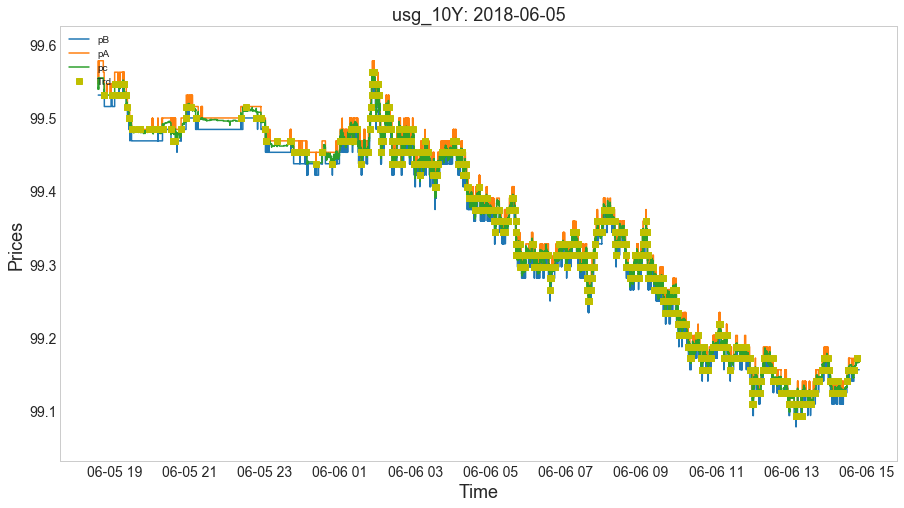

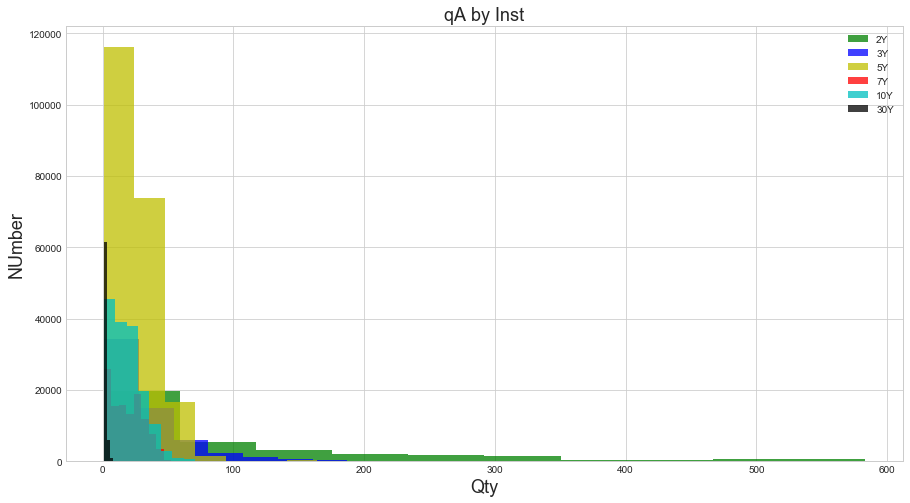

In [36]:
# Plot one inst

def plotOneInst(df, instNum):
    
    maskInst = df['instNum'] == instNum
    dfInst = df.loc[maskInst,:]
    maskTrd = abs(dfInst['vol'].pct_change() ) > 1.e-8
    spread = dfInst['pA'] - dfInst['pB'] 
    minIncr = np.min(spread[spread>1.e-8])

    plt.figure(1)
    plt.plot(dfInst.index, dfInst['pB'], label='pB', drawstyle='steps')
    plt.plot(dfInst.index, dfInst['pA'], label='pA', drawstyle='steps')
    plt.plot(dfInst.index, dfInst['pc'], label='pc', drawstyle='steps')       # NOTE pc is grabbed from ds
    plt.plot(dfInst.index[maskTrd] .values, dfInst['pT'][maskTrd].values, 'ys', label='Trd')
    plt.ylim((min(dfInst['pB']) - 3*minIncr, max(dfInst['pA']) + 3*minIncr))
    plt.title('%s: %s' % (dfInst['Name'][0], dfInst.index[0].strftime('%Y-%m-%d')), fontsize=18)
    plt.xlabel('Time', fontsize=18)
    plt.ylabel('Prices', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.legend(loc='upper left')
    plt.gcf().set_size_inches(15, 8)
    ax = plt.gca()
    #ax.get_yaxis().get_major_ formatter().set_scientific( False)
    ax.get_yaxis().get_major_formatter().set_useOffset( False)
    plt.grid()
    plt.show()
    
    plt.figure(2)
    bins = np.arange(0, 100, 5)
    plt.hist(df[df['instNum'] == 0]['qA'], facecolor='g', alpha=0.75, label='2Y')
    plt.hist(df[df['instNum'] == 1]['qA'], facecolor='b', alpha=0.75, label='3Y')
    plt.hist(df[df['instNum'] == 2]['qA'], facecolor='y', alpha=0.75, label='5Y')
    plt.hist(df[df['instNum'] == 3]['qA'], facecolor='r', alpha=0.75, label='7Y')
    plt.hist(df[df['instNum'] == 4]['qA'], facecolor='c', alpha=0.75, label='10Y')
    plt.hist(df[df['instNum'] == 5]['qA'], facecolor='k', alpha=0.75, label='30Y')
    plt.title('qA by Inst', fontsize=18)
    plt.xlabel('Qty', fontsize=18)
    plt.ylabel('NUmber', fontsize=18)
    plt.legend(loc='upper right')
    plt.gcf().set_size_inches(15, 8)

# call function
instNum = 4
plotOneInst(dfEsp, instNum)

C:\Users\sup\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


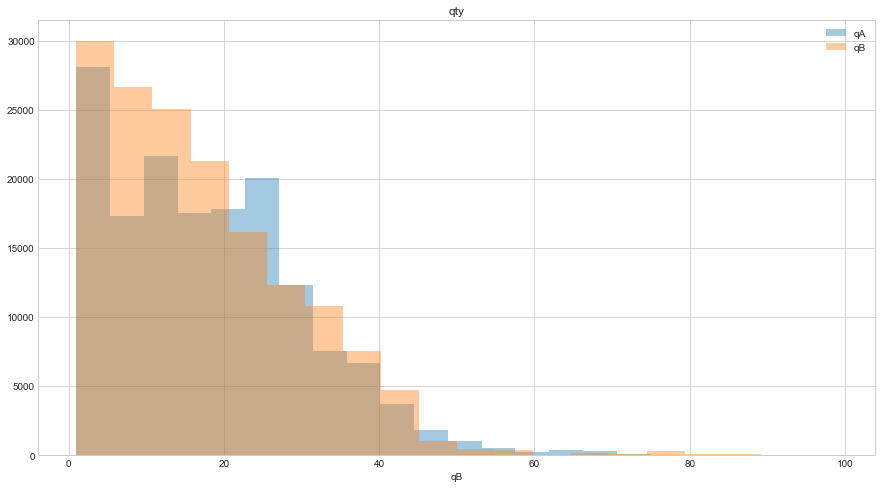

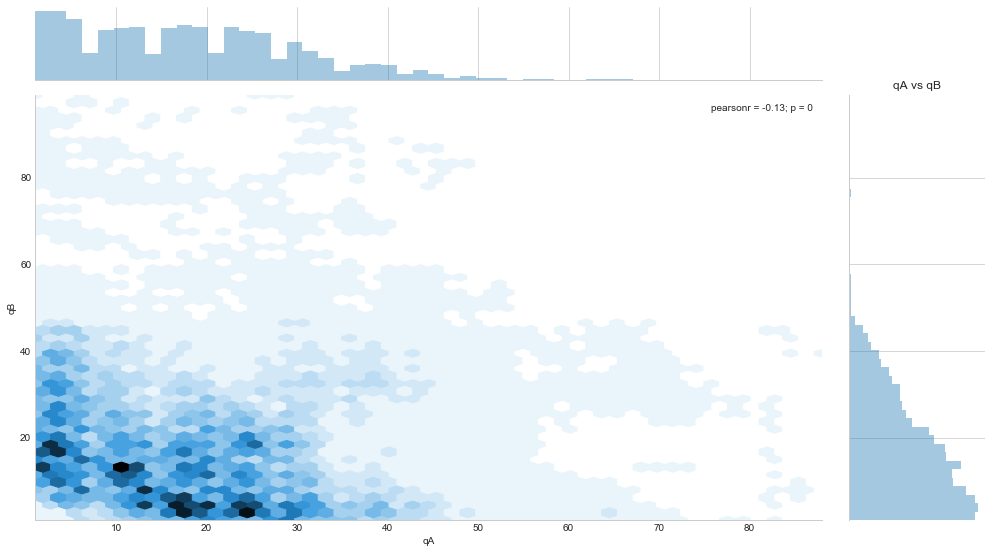

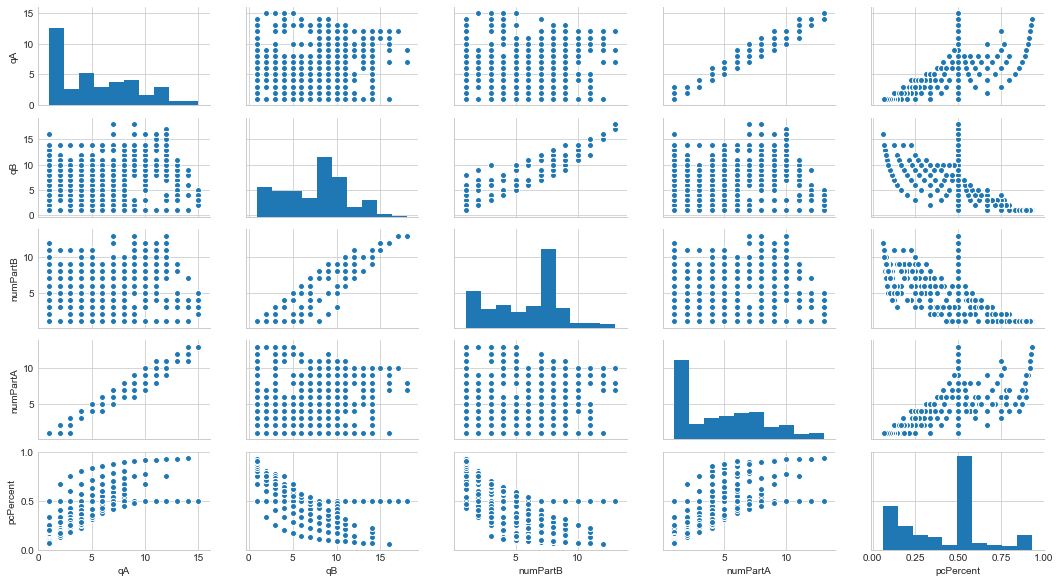

In [32]:
# Plot with Seaborn. Usually I use matplotlib for all plots but want to explore this package
from scipy import stats, integrate
import seaborn as sns
sns.set_style("whitegrid")

def plotsSeaborn(df, instNum):
    
    maskInst = df['instNum'] == instNum
    dfInst = df.loc[maskInst,:]
    
    #--------------
    sns.distplot(dfInst['qA'], bins=20, kde=False, rug=False, label='qA');
    sns.distplot(dfInst['qB'], bins=20, kde=False, rug=False, label='qB');
    plt.legend();
    plt.title('qty')
    plt.gcf().set_size_inches(15, 8)
    plt.show()
    
    #--------------
    sns.jointplot(x="qA", y="qB", kind="hex", bins=20, data=dfInst);
    plt.title('qA vs qB')
    plt.gcf().set_size_inches(15, 8)
    plt.show()
    
    #--------------
    sns.pairplot(dfInst.iloc[0:1000], vars=['qA', 'qB', 'numPartB', 'numPartA', 'pcPercent']);  
    plt.gcf().set_size_inches(15, 8)
    plt.show()

# call function
instNum = 4
plotsSeaborn(dfEsp, instNum)